# Tensor basics

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import torch
import numpy as np
 
w = torch.tensor(1, dtype=torch.float32)
x = torch.tensor(2.0, dtype=torch.float32)
t = torch.tensor(np.float32(3))
b = torch.tensor(4, dtype=torch.float32)

In [65]:
w.requires_grad = True

In [66]:
a = x + b
y = torch.maximum(a * w, torch.zeros(1))
l = (y - t) ** 2 + w ** 2

In [67]:
l.grad_fn

In [68]:
y.grad_fn

In [69]:
a.grad_fn

In [70]:
from torch.autograd import grad

l.retain_graph = True
grad(l, y, retain_graph=True)

(tensor([6.]),)

In [71]:
l.backward()

In [72]:
w.grad

tensor(38.)

In [73]:
with torch.no_grad():
    w = w - 0.1 * w.grad

# Gradient and Network Training

## Step 1

In [74]:
from template import G2Model

G = G2Model()
train_data = G.generate_sample(100)
test_data = G.generate_sample(50)
x, y = train_data

In [75]:
from model import FFModel

model = FFModel(500, 'cpu', torch.float32)
loss = model.mean_loss(x, y)
loss.backward()

## Step 2

In [76]:
for p in ['w1', 'b1', 'w2', 'b2']:
    model.check_gradient(x, y, p, eps=1e-4)

# Grad error in w1: 0.0002736
# Grad error in b1: 0.0001608
# Grad error in w2: 0.0002191
# Grad error in b2: 6.616e-06


## Step 3

Remark: *Boundary plots are the files model_5.png, model_100.png and model_500.png*

Computing the optimal test size from the Hoeffding inequality:

2 * e^(-2 * m * eps^2) = 0.01

-2 * m * eps^2 = ln(0.005)

m = - ln(0.005) / (2 * eps^2)

m = 11505.1499783 ~= 11506 (samples)

With the test size above I got the next results:

test error = 1 - 0.967 = 0.033

generalization gap = 0.012

So even with 1% there's still realistic chance generalization gap to be higher

All the source code can be found in **main.py**/**model.py**

# Test error

In [77]:
m = FFModel(500, 'cpu', torch.float32)
train_data = G.generate_sample(200)

In [78]:
def train(model, data, lr=1e-1, epochs=100):
    for _ in range(epochs):
        l = model.mean_loss(*data)
        model.zero_grad()
        l.backward()
        for p in model.parameters:
            p.data -= lr * p.grad.data
            
train(m, train_data)
m.mean_accuracy_working_function(*train_data)

0.98

**Everytime** I run this loop with 10000 trials, my PC is crashing, so I better decrease the number of trials to 1000

In [79]:
errors = []

for _ in range(1000):
    errors.append(1 - m.mean_accuracy_working_function(*G.generate_sample(1000)))

Text(0.5, 0, 'Error (%)')

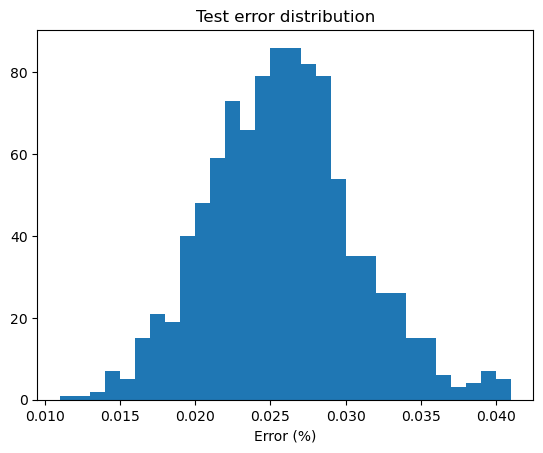

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(errors, bins=30)
plt.title('Test error distribution')
plt.xlabel('Error (%)')

## Hoeffding

2e ^ (-2m eps^2) = 1 - 0.95

e ^ (-2m eps^2) = 0.025

-2m eps^2 = -3.68887945411

m eps^2 = 1.84443972705

eps^2 = 0.00184443972

eps = 0.04294694075 ~= 0.043

In [81]:
test_data = G.generate_sample(1000)
eps = 0.043
err = 1 - m.mean_accuracy_working_function(*test_data)
print(f'Test error: {err:.3f} +- {eps}')

Test error: 0.030 +- 0.043


## Chebyshev

V / (m eps^2) = 0.05

1 / (m eps^2) = 0.05 / V

m eps^2 = V / 0.05

eps^2 = V / (0.05m)

eps = sqrt(V / (0.05m))

In [91]:
x, y = test_data
y_hat = model.classify(x).detach().numpy()
var = np.var(y != y_hat)
eps = np.sqrt(var / (0.05 * 1000))
eps
print(f'Test error: {err:.3f} +- {eps}')

Test error: 0.030 +- 0.06511144292672372


Obviously I made a mistake, the final test error doesn't make sense, but I can't see it